In [10]:
import os
import cv2
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd

In [11]:
# Define paths
train_dir = "dataset/datasetsplitted/train"
test_dir = "dataset/datasetsplitted/test"

# Check if dataset directories exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError("Dataset directories not found. Please verify the path.")

In [12]:
# Function to extract HSV histogram features
def extract_hsv_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

In [13]:
# Collecting descriptors for images
image_features = []
image_paths = []

# Read images and extract HSV features
for car_model in os.listdir(train_dir):
    model_path = os.path.join(train_dir, car_model)
    
    if os.path.isdir(model_path):
        for img_name in tqdm(os.listdir(model_path), desc=f"Processing {car_model}"):
            img_path = os.path.join(model_path, img_name)
            features = extract_hsv_features(img_path)
            if features is not None:
                image_features.append(features)
                image_paths.append(img_path)

Processing volkswagen tiguan: 100%|██████████| 147/147 [00:00<00:00, 1884.11it/s]


In [14]:
# Convert features to a consistent format
X = np.array(image_features)

# Estimate bandwidth for Mean-Shift
bandwidth = estimate_bandwidth(X, quantile=0.1, n_samples=500)

# Fit Mean-Shift clustering model
mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=False, max_iter=500, cluster_all=True, min_bin_freq=20)
labels = mean_shift.fit_predict(X)

# Number of clusters detected
num_clusters = len(np.unique(labels))

# Compute Silhouette Score
silhouette = silhouette_score(X, labels)

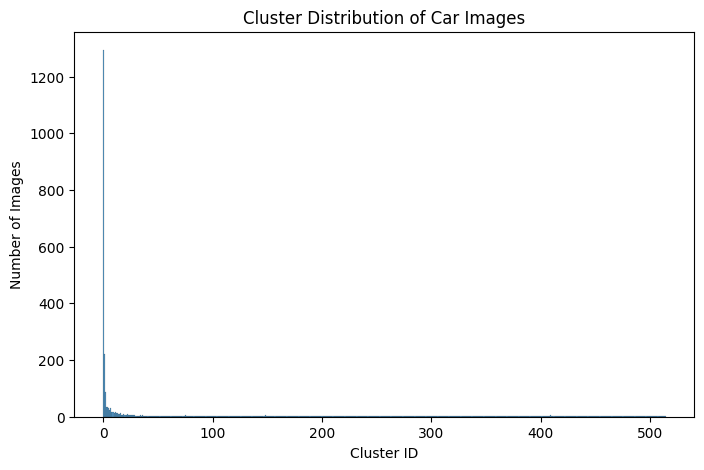

In [15]:
#Plot Cluster Distribution
plt.figure(figsize=(8, 5))
sns.histplot(labels, bins=num_clusters, kde=False, discrete=True)
plt.xlabel("Cluster ID")
plt.ylabel("Number of Images")
plt.title("Cluster Distribution of Car Images")
plt.show()

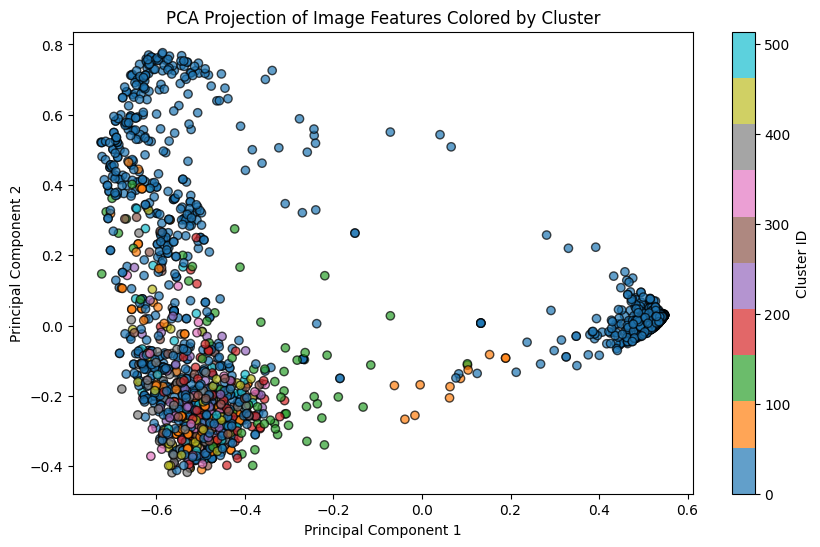

In [16]:
# PCA Projection for 2D visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="tab10", alpha=0.7, edgecolors="k")
plt.colorbar(label="Cluster ID")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Image Features Colored by Cluster")
plt.show()

In [17]:
# Print cluster information
print(f"Number of Clusters: {num_clusters}")
print(f"Silhouette Score: {silhouette}")



Number of Clusters: 515
Silhouette Score: 0.4514042139053345


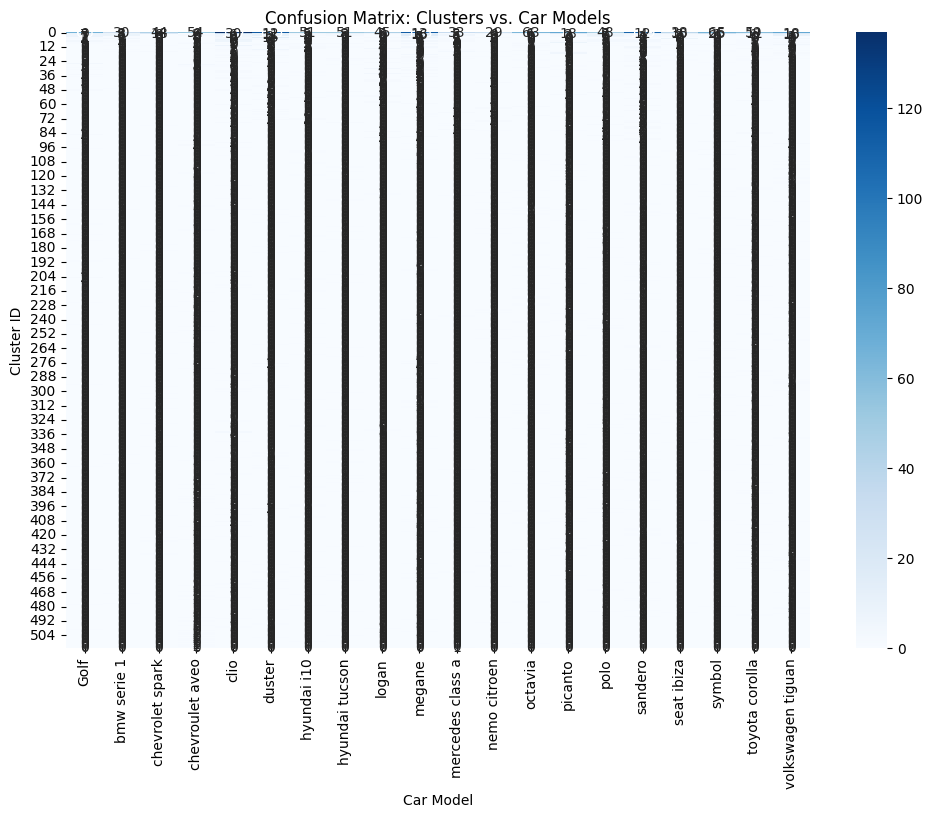

In [18]:

# Create a DataFrame to map image paths to their cluster assignments
df = pd.DataFrame({"Image": image_paths, "Cluster": labels})

# Extract car model names from the image paths (assuming the folder structure is "train_dir/car_model/image.jpg")
df["CarModel"] = df["Image"].apply(lambda x: os.path.basename(os.path.dirname(x)))

# Create confusion matrix to compare clusters with car models
conf_matrix = pd.crosstab(df["Cluster"], df["CarModel"])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Car Model")
plt.ylabel("Cluster ID")
plt.title("Confusion Matrix: Clusters vs. Car Models")
plt.show()
